##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lab 02 Predicting Survivors of the Titanic

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rses-dl-course/rses-dl-course.github.io/blob/master/notebooks/python/L02_classifying_images_of_clothing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/rses-dl-course/rses-dl-course.github.io/blob/master/notebooks/python/L02_classifying_images_of_clothing.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this tutorial, we'll build and train a neural network to predict survivors of the Titanic.

It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies

In [ ]:
!pip install liac-arff

In [22]:
import tensorflow as tf

In [23]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import arff

In [24]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Importing the Titanic dataset

This guide uses the original Titanic dataset, describing the survival status of individual passengers on the Titanic. The titanic data does not contain information from the crew, but it does contain actual ages of half of the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. The datasets used here were begun by a variety of researchers. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay. 

Various versions of the data exists but this particular one was obtained from [openml.org](https://www.openml.org/search?type=data&sort=runs&id=40945&status=active). 


It contains the records of 1309 passengers with the following attributes:


| Feature | Desciption|
| ------- | --------- |
| pclass | Refers to passenger class (1st, 2nd, 3rd), and is a proxy for socio-economic class  |
| survived | 1 (survived) or 0 (died) |
| name | Name of the passenger |
| sex | Sex |
| age | Age is in years, and some infants had fractional values |
| subsp | # of siblings / spouses aboard the Titanic |
| parch | # of parents / children aboard the Titanic 	 |
| ticket | Ticket number|
| fare | Passenger fare |
| cabin | The cabin number |
| embarked | Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton |
| boat | Lifeboat no. (if survived) |
| body | Body ID if recovered (did not survive) |
| home.dest | Starting and ending destination |

> Notes on the variables
>
> * subsp: The dataset defines family relations in this way...
>   * Sibling = brother, sister, stepbrother, stepsister
>   * Spouse = husband, wife (mistresses and fiancés were ignored)
>
> * parch: The dataset defines family relations in this way...
>   * Parent = mother, father
>   * Child = daughter, son, stepdaughter, stepson
>   * Some children travelled only with a nanny, therefore parch=0 for them.


## Exercise 2.1

What columns should we use as our feature and target?

## Exploring the dataset

Let's load the value first

.arff Attribute-Relation File Format 

we've used `liac-arff` library to load the data as string attribute is not supported in scipy's loader

In [28]:
titanic_data_raw = arff.load(open("titanic.arff", "r"))
titanic_data_raw

{'description': '',
 'relation': 'd',
 'attributes': [('pclass', 'NUMERIC'),
  ('survived', ['0', '1']),
  ('name', 'STRING'),
  ('sex', ['female', 'male']),
  ('age', 'NUMERIC'),
  ('sibsp', 'NUMERIC'),
  ('parch', 'NUMERIC'),
  ('ticket', 'STRING'),
  ('fare', 'NUMERIC'),
  ('cabin', 'STRING'),
  ('embarked', ['C', 'Q', 'S']),
  ('boat', 'STRING'),
  ('body', 'NUMERIC'),
  ('home.dest', 'STRING')],
 'data': [[1.0,
   '1',
   'Allen, Miss. Elisabeth Walton',
   'female',
   29.0,
   0.0,
   0.0,
   '24160',
   211.3375,
   'B5',
   'S',
   '2',
   None,
   'St Louis, MO'],
  [1.0,
   '1',
   'Allison, Master. Hudson Trevor',
   'male',
   0.9167,
   1.0,
   2.0,
   '113781',
   151.55,
   'C22 C26',
   'S',
   '11',
   None,
   'Montreal, PQ / Chesterville, ON'],
  [1.0,
   '0',
   'Allison, Miss. Helen Loraine',
   'female',
   2.0,
   1.0,
   2.0,
   '113781',
   151.55,
   'C22 C26',
   'S',
   None,
   None,
   'Montreal, PQ / Chesterville, ON'],
  [1.0,
   '0',
   'Allison, Mr. H

Getting the column names that will be used in the table

In [68]:
column_names = []
for attribute in titanic_data_raw["attributes"]:
    column_names.append(attribute[0])

column_names

['pclass',
 'survived',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked',
 'boat',
 'body',
 'home.dest']

Create a dataframe from our data

In [69]:
titanic_df_raw = pd.DataFrame(titanic_data_raw["data"], columns=column_names)
titanic_df_raw

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C,None,328.0,None
1305,3.0,0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C,None,NaN,None
1306,3.0,0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C,None,304.0,None
1307,3.0,0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C,None,NaN,None


Check for missing values too

In [70]:
titanic_df_raw.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

What can we say about the data?

Selecting our feature and target columns

Removed name - is text
Boat and body is not needee, just use survived
cabin - simplifying this, using fare value instead
ticket - also simplifying
home.dest - has embark value

In [71]:
titanic_df_reduced = titanic_df_raw.drop(["name","cabin","boat","body", "ticket","home.dest"], axis=1)
titanic_df_reduced

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1,female,29.0000,0.0,0.0,211.3375,S
1,1.0,1,male,0.9167,1.0,2.0,151.5500,S
2,1.0,0,female,2.0000,1.0,2.0,151.5500,S
3,1.0,0,male,30.0000,1.0,2.0,151.5500,S
4,1.0,0,female,25.0000,1.0,2.0,151.5500,S
...,...,...,...,...,...,...,...,...
1304,3.0,0,female,14.5000,1.0,0.0,14.4542,C
1305,3.0,0,female,NaN,1.0,0.0,14.4542,C
1306,3.0,0,male,26.5000,0.0,0.0,7.2250,C
1307,3.0,0,male,27.0000,0.0,0.0,7.2250,C


Convert sex and embark to a number

In [72]:
titanic_df_convert = titanic_df_reduced.replace(["male","female"], [1, 2]).replace(["C","S","Q"], [1, 2, 3])
titanic_df_convert


,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1,2,29.0000,0.0,0.0,211.3375,2.0
1,1.0,1,1,0.9167,1.0,2.0,151.5500,2.0
2,1.0,0,2,2.0000,1.0,2.0,151.5500,2.0
3,1.0,0,1,30.0000,1.0,2.0,151.5500,2.0
4,1.0,0,2,25.0000,1.0,2.0,151.5500,2.0
...,...,...,...,...,...,...,...,...
1304,3.0,0,2,14.5000,1.0,0.0,14.4542,1.0
1305,3.0,0,2,NaN,1.0,0.0,14.4542,1.0
1306,3.0,0,1,26.5000,0.0,0.0,7.2250,1.0
1307,3.0,0,1,27.0000,0.0,0.0,7.2250,1.0


Let's check for missing values again

In [73]:
titanic_df_convert.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

We'll drop the all the row with null values for convenience as we'd like to be able to make predictions for age

In some cases it might be sensible to replace with average value but age should actually be an important factor

In [74]:
titanic_df = titanic_df_convert.dropna()
titanic_df

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1,2,29.0000,0.0,0.0,211.3375,2.0
1,1.0,1,1,0.9167,1.0,2.0,151.5500,2.0
2,1.0,0,2,2.0000,1.0,2.0,151.5500,2.0
3,1.0,0,1,30.0000,1.0,2.0,151.5500,2.0
4,1.0,0,2,25.0000,1.0,2.0,151.5500,2.0
...,...,...,...,...,...,...,...,...
1301,3.0,0,1,45.5000,0.0,0.0,7.2250,1.0
1304,3.0,0,2,14.5000,1.0,0.0,14.4542,1.0
1306,3.0,0,1,26.5000,0.0,0.0,7.2250,1.0
1307,3.0,0,1,27.0000,0.0,0.0,7.2250,1.0


Also useful to check the column's datatype

In [ ]:
titanic_df.dtypes

In [79]:
titanic_df = titanic_df.astype({"pclass": "int32", "survived":"int32", "sex": "int32", "embarked": "int32"})

In [80]:
titanic_df.dtypes

pclass        int32
survived      int32
sex           int32
age         float64
sibsp       float64
parch       float64
fare        float64
embarked      int32
dtype: object

Making a baic histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8eb7f8a910>,
      dtype=object)

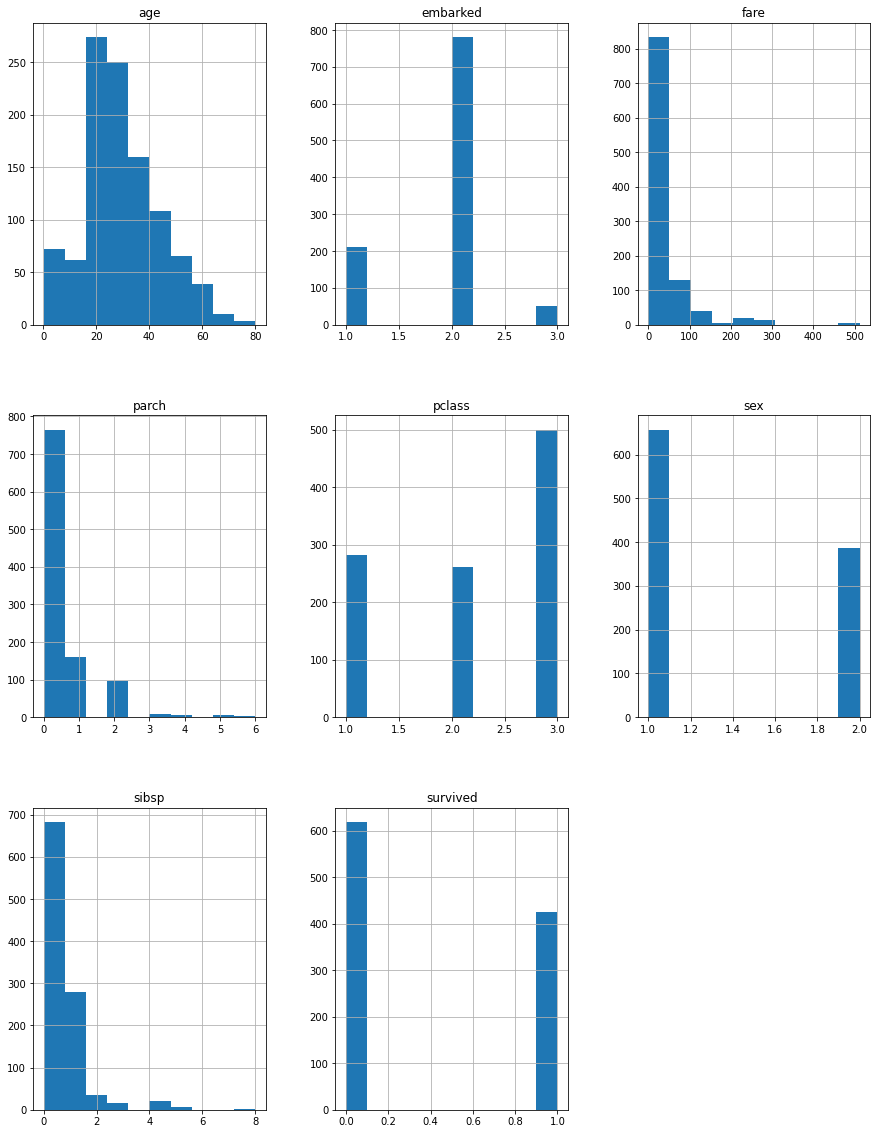

In [82]:
titanic_df.hist(figsize=(15,20))

What about correlation to survival

In [83]:
titanic_df["survived"].corr(titanic_df["age"])

-0.05741554860841191

In [85]:
tgroup = titanic_df.groupby(titanic_df["survived"])

In [90]:
gx = [ g for g in tgroup]
    

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8eb7b67c90>,
      dtype=object)

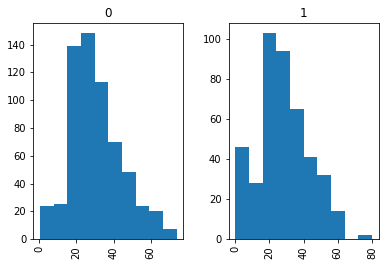

In [95]:
titanic_df["age"].hist(by=titanic_df["survived"])

In [94]:
titanic_df

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,2,29.0000,0.0,0.0,211.3375,2
1,1,1,1,0.9167,1.0,2.0,151.5500,2
2,1,0,2,2.0000,1.0,2.0,151.5500,2
3,1,0,1,30.0000,1.0,2.0,151.5500,2
4,1,0,2,25.0000,1.0,2.0,151.5500,2
...,...,...,...,...,...,...,...,...
1301,3,0,1,45.5000,0.0,0.0,7.2250,1
1304,3,0,2,14.5000,1.0,0.0,14.4542,1
1306,3,0,1,26.5000,0.0,0.0,7.2250,1
1307,3,0,1,27.0000,0.0,0.0,7.2250,1


### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets. 
train_dataset_norm =  train_dataset_raw.map(normalize)
test_dataset_norm  =  test_dataset_raw.map(normalize)


### Explore the processed data

Let's plot an image to see what it looks like.

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset_norm.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

In [ ]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset_norm.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Exercise 2.1 Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

This network has three layers:

* **input** `tf.keras.layers.Flatten` — This layer transforms the images from a 2d-array of 28 $\times$ 28 pixels, to a 1d-array of 784 pixels (28\*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

* **"hidden"** `tf.keras.layers.Dense`— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

* **output** `tf.keras.layers.Dense` — A 10-node *softmax* layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

**The code below alredy has the first `flatten` layer, add the other two `Dense` layers to complete our model.**
* The hidden layer uses an activation function, you'll need to add an extra parameter `activation=tf.nn.relu`.
* The output layer uses the 'softmax' activation function, you'll need to add an extra parameter `activation='softmax'`

In [ ]:
raise Exception('This cell has a TODO task! Please complete the TODO task and remove the raise Exception statement.')

model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    # TODO: Add dense hidden layer
    
    # TODO: Add dense output layer
    
])

#### Exercise 2.1 Solution

The solution for the exercise can be found [here](https://colab.research.google.com/github/rses-dl-course/rses-dl-course.github.io/blob/master/notebooks/python/solutions/E2.1.ipynb)

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. The `dataset.cache()` will keep the data in memory, making training faster. 
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset_processed`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.


In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset_norm.cache().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset_norm.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=5, validation_data=test_dataset)

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.88 (or 88%) on the training data.

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [ ]:
predictions.shape


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

So the model is most confident that this image is a shirt, or `class_names[6]`. And we can check the test label to see this is correct:

In [ ]:
test_labels[0]

We can graph this to look at the full set of 10 class predictions

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image. 

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

Now predict the image:

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

And, as before, the model predicts a label of 4 (Coat).

# Exercise 2.2

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final `Dense(10)`, experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has




# Notice
Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes